In [1]:
import trimesh
import numpy as np
from collections import Counter
import time
from tqdm import tqdm

In [2]:
new_mesh = trimesh.load_mesh("in_out_filtered_mesh.off")

In [ ]:
faces_in_facet = [1282044,1292797]

In [ ]:
#get the index of the faces in facet
for i,facet in enumerate(new_mesh.facets):
    facet_list = facet.tolist()
    if len(set(facet_list).intersection(set(faces_in_facet))) > 0:
        print(f"facet {i}: {facet_list}")
    


In [ ]:
#get the facet area
#new_mesh.facets_boundary[114093] #these just return the edges of the boundary
to_check = [72280]

total_normals = []
for group in to_check:
    print("area = " + str(new_mesh.facets_area[group]))
    print("nomral = " + str(new_mesh.facets_normal[group]))
    total_normals.append(new_mesh.facets_normal[group])

In [3]:
"""
Facet Strategy:
1) Get facet groups
2) Use initial size filtering on facets
3) For each group still left do expanding algorithm:
a. For each face in facet:
    Get list of all faces and for each face:
        check neighbor faces to see if close enough to facet normals
            if yes --> add to "To add list" and the list to check all of the adjacent faces
    reconstruct the group into true facet list

4) Compute the sizes of all of the new facets and send through another size filter
"""

'\nFacet Strategy:\n1) Get facet groups\n2) Use initial size filtering on facets\n3) For each group still left do expanding algorithm:\na. For each face in facet:\n    Get list of all faces and for each face:\n        check neighbor faces to see if close enough to facet normals\n            if yes --> add to "To add list" and the list to check all of the adjacent faces\n    reconstruct the group into true facet list\n\n4) Compute the sizes of all of the new facets and send through another size filter\n'

In [4]:
"""
1) Get the original facets group

"""
len(new_mesh.facets_area)

121529

In [5]:
first_pass_size_threshold = 2000
"""
#2) Use initial size filtering on facets
"""
new_facets = new_mesh.facets[np.where(new_mesh.facets_area > first_pass_size_threshold)[0]]
new_facets


array([array([5, 6, 7]), array([8, 9]), array([  31, 2126,   14]), ...,
       array([2187572, 2187503, 2187502]), array([2187557, 2187556]),
       array([2187601, 2187602, 2187594, 2187614])], dtype=object)

In [69]:
# need a way of finding the neighbors that have to share adjacent faces
def create_neighbors_lookup(mesh):
    start_time = time.time()
    neighbors_lookup = dict([(i,[]) for i in range(0,len(mesh.faces))])
    print(f"Creating empty dictionary : {time.time() - start_time}")
    
    start_time = time.time()
    for adj in mesh.face_adjacency:
        neighbors_lookup[adj[0]].append(adj[1])
        neighbors_lookup[adj[1]].append(adj[0])
    print(f"Filling in neighbors lookup : {time.time() - start_time}")
    
    return neighbors_lookup
    
    

In [73]:
neighbors_lookup = create_neighbors_lookup(new_mesh)

Creating empty dictionary : 6.729601860046387
Filling in neighbors lookup : 5.016799688339233


In [74]:
def find_neighbors(current_face):
    return neighbors_lookup[current_face]

In [8]:
def find_neighbors_non_adjacent(current_face):
    #print("hellloooo")
    total_list = []
    for k in new_mesh.faces[current_face]:
        #possible neighbors before filtering
        possible_neighbors = verts_to_face[k]
        #need to make sure that they at least share an edge
        total_list = total_list + verts_to_face[k]
    
    return list(set(total_list))

In [ ]:
# def find_neighbors_numpy(current_face):
#     total_neighbors = np.unique(np.hstack([verts_to_face[k] for k in new_mesh.faces[current_face]]))
#     return total_neighbors

In [ ]:
# def find_neighbors_adjacency(current_face):
#     neighbors_and_self = np.hstack([new_mesh.face_adjacency[new_mesh.face_adjacency[:,1] == current_face].ravel(),
#                                     new_mesh.face_adjacency[new_mesh.face_adjacency[:,0] == current_face].ravel()])
#     neighbors = neighbors_and_self[neighbors_and_self != current_face]
#     return neighbors

In [ ]:
# #find neighbors using verts_to_face:
# example_face = 5
# start_time = time.time()
# total_neighbors = np.unique(np.hstack([verts_to_face[k] for k in new_mesh.faces[example_face]]))
# print(total_neighbors)
# print(len(total_neighbors))
# print(f"Total_time:{time.time() - start_time}")

# start_time = time.time()
# total_neighbors_adjacency = find_neighbors_adjacency(example_face)
# print(total_neighbors_adjacency)
# print(f"Total_time:{time.time() - start_time}")

# #this one appears to be the fastest!! Using just lists
# start_time = time.time()
# total_neighbors_adjacency = find_neighbors(example_face)
# print(total_neighbors_adjacency)
# print(len(total_neighbors_adjacency))
# print(f"Total_time:{time.time() - start_time}")

In [77]:
#generate a normals lookup table and see if works faster than regular lookup
normal_lookup = {}

for i in range(0,len(new_mesh.faces)):
    normal_lookup[i] = new_mesh.face_normals[i]

In [78]:
len(normal_lookup.keys()),len(new_mesh.faces)

(2187653, 2187653)

In [79]:
"""
3) For each group still left do expanding algorithm:
a. For each face in facet:
    Get list of all faces and for each face:
        check neighbor faces to see if close enough to facet normals
            if yes --> add to "To add list" and the list to check all of the adjacent faces
    reconstruct the group into true facet list

"""

normal_closeness = 0.985

global_start_time = time.time()
final_facets= [0]*len(new_facets)


for i,facet in tqdm(enumerate(new_facets)):
#     mini_global_start_time = time.time()
#     print(facet)
#     print(type(facet))
#     start_time = time.time()
#     print([find_neighbors(k) for k in facet])
    total_neighbors = list(set(np.hstack([find_neighbors(k) for k in facet])).difference(set(facet)))
#     print(total_neighbors)
#     print(f"time initial neighbors: {(time.time() - start_time)}")
    neighbors_to_add = []
    neighbors_checked = []
    #print(total_neighbors)
    
    #just get the normal from one of the faces already in the facet
#     start_time = time.time()
    facet_normal = normal_lookup[facet[0]]
    
#     total_dot_time = 0
    while len(total_neighbors) > 0:
        current_neighbor = total_neighbors.pop()
        neighbors_checked.append(current_neighbor)
        
#         print("--------------")
# #         #check to see if neighbor has same normal face
# #         start_dot_time = time.time()
# #         dot_result = np.dot(new_mesh.face_normals[current_neighbor],facet_normal) #> normal_closeness
# #         print(dot_result)
# #         print((time.time() - start_dot_time) * 1000)
        
#         start_dot_time = time.time()
#         print(current_neighbor)
#         #a = new_mesh.face_normals[current_neighbor]
        
#         print((time.time() - start_dot_time) * 1000)
#         dot_result = a[0]*facet_normal[0] + a[1]*facet_normal[1] + a[2]*facet_normal[2]  > normal_closeness
#         print(dot_result)
#         print((time.time() - start_dot_time) * 1000)
#         print("--------------")
        
#         total_dot_time += (time.time() - start_dot_time)*1000
        
        a = normal_lookup[current_neighbor]
        if a[0]*facet_normal[0] + a[1]*facet_normal[1] + a[2]*facet_normal[2]  > normal_closeness:
            
            neighbors_to_add.append(current_neighbor)
            #get the neighbors of this current face
            for neigh in find_neighbors(current_neighbor) :
                #only add those neighbors that havent already been checked, in original facet group, or already in list to check
                if neigh not in neighbors_checked and neigh not in facet and neigh not in total_neighbors:
                    total_neighbors.append(neigh)
#     print(f"Total dot time: {total_dot_time}")
#     print(f"time loop: {(time.time() - start_time)}")
#     print("neighbors_to_add = " + str(neighbors_to_add))
#     print("neighbors_checked = " + str(neighbors_checked))
#     print("adding list = " + str(list(facet) + neighbors_to_add))
#     start_time = time.time()
    final_facets[i] = list(facet) + neighbors_to_add
#     print(f"Appending to list: {(time.time() - start_time)}")
    
#     print(f"Total time: {(time.time() - mini_global_start_time)}")
#     print("------------------------------------------------------")


print(f"Total Facet building time: {(time.time() - global_start_time)}")
                          


70406it [00:09, 7567.96it/s]

Total Facet building time: 9.309107780456543


# AT THIS POINT THERE may be redundant facets but that is fine (will just need to pick biggest)

In [80]:
# download the facets list and see if the process worked:
facets_group = np.zeros(len(new_mesh.faces)).astype(int)

for i,facet_group in enumerate(final_facets):
    for face in facet_group:
        facets_group[face] = i + 1 #so that you reserve the label 0 for blenders none

np.savez("./convex_stats/facets_group_revised.npz",facets_group=facets_group)

""" Conclusion:
They look good so far,
now see if can filter them by size

"""

' Conclusion:\nThey look good so far,\nnow see if can filter them by size\n\n'

In [36]:
trimesh.triangles.area

<module 'trimesh.triangles' from '/usr/local/lib/python3.6/dist-packages/trimesh/triangles.py'>

In [55]:
#Try to find the example
ex_face = [5,6,7]
area_input = np.array(new_mesh.vertices[new_mesh.faces[ex_face]])
#area_sum = trimesh.triangles.area(new_mesh.vertices[new_mesh.faces[ex_face]],sum=True)
print(area_input)
area_sum = trimesh.triangles.area(area_input,sum=True)
area_sum

[[[372785.9375    194954.53125    36397.2890625]
  [372736.        194992.         36400.       ]
  [372736.        195008.         36380.       ]]

 [[372785.9375    194954.53125    36397.2890625]
  [372736.        194976.         36420.       ]
  [372736.        194992.         36400.       ]]

 [[372785.9375    194954.53125    36397.2890625]
  [372736.        194960.         36440.       ]
  [372736.        194976.         36420.       ]]]


2257.1661505635775

In [54]:
new_mesh.facets_area

array([ 2257.16615056, 12194.3495481 ,  1387.37893616, ...,
        4718.94987325,  1839.79514824,  1551.49370693])

In [ ]:
def tri_area(mesh,face_number):
    
    

In [56]:
final_facets_area = np.zeros(len(final_facets))
for i,facet in enumerate(final_facets):
    area_input = np.array(new_mesh.vertices[new_mesh.faces[facet]])
    final_facets_area[i] = trimesh.triangles.area(area_input,sum=True)

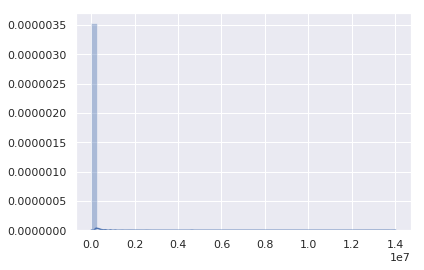

In [59]:
import seaborn as sns
sns.set()

sns.distplot(final_facets_area)


In [64]:
sum(final_facets_area < 10000)

28545

In [60]:
#Download the sizes and then can do the filtering on the Blender side

facets_group_area = np.zeros(len(new_mesh.faces)).astype(int)

for i,facet_group in enumerate(final_facets):
    for face in facet_group:
        facets_group_area[face] = final_facets_area[i]

np.savez("./convex_stats/facets_group_area_revised.npz",facets_group_area=facets_group_area)


# CAN USE MATCHING NORMALS TO HELP STITCH BACK UP! EVEN OVERLAY WITH HIGH CONVEX BOUNDARIES

# Found the dot product wsa taking the longest time (testing how to do it faster)
# --> but actually the normal vector lookup of certain faces was taking a while
# --> so just had to make my own lookup table

In [ ]:
# np.dot(new_mesh.face_normals[current_neighbor]*facet_normal) --> original way
a = new_mesh.face_normals[2]
b = new_mesh.face_normals[3]

start_time = time.time()
a = new_mesh.face_normals[2]
b = new_mesh.face_normals[3]
print(np.dot(a,b)  )#> normal_closeness)
print(f" time: {(time.time() - start_time)*1000}")


#slightly faster to do it manually ... but doesn't explain time lag in loop
start_time = time.time()
a = new_mesh.face_normals[2]
b = new_mesh.face_normals[3]
print(a[0]*b[0] + a[1]*b[1] + a[2]*b[2] )# > normal_closeness)
print(f" time: {(time.time() - start_time)*1000}")


In [ ]:
#     start_time = time.time()
#     total_neighbors = list(set(np.hstack([find_neighbors(k) for k in facet])).difference(set(facet)))
#     print(f"total time {time.time() - start_time}")
    
#     start_time = time.time()
    total_neighbors = []
    for k in facet:
        total_neighbors + find_neighbors(k)
    total_neighbors = list(set(total_neighbors).difference(set(facet)))
    print(f"total time {time.time() - start_time}")

In [ ]:
x = np.array([4,5,6])
list(np.unique(np.hstack([x,[4,56,7]])))

In [ ]:
total_neighbors.pop()

In [ ]:
total_neighbors

In [ ]:
len(new_mesh.face_normals),len(new_mesh.faces)